In [1]:
# Fundamental tools for Data Science 
import pandas as pd
import numpy as np

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns 


# Missing Values Detection
import missingno as msno


# Models
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier


# for models 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import mutual_info_classif

# METRICS
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.calibration import calibration_curve
from sklearn.metrics import plot_precision_recall_curve
from yellowbrick.classifier import ClassificationReport

#Tree Visualization and saving as pdf
from dtreeviz.trees import *
from svglib.svglib import svg2rlg
from reportlab.graphics import renderPDF, renderPM


# Warnings
import warnings
from pandas.core.common import SettingWithCopyWarning
from warnings import simplefilter

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
simplefilter(action='ignore', category=FutureWarning)

path = "C:\\Users\\hp\\Desktop\\DataCamp Data\\Credit Risk\\rawcredit.csv"

# Read Data
df = pd.read_csv(path)

# new column names for readability
new_columns_names = ["age","income","ownership","emp_time","intent","grade","amount","int_rate","target","loan_percent_income","default_on_file",
"cred_hist"]
df.columns = new_columns_names

# Introducing
df.head(3)

,age,income,ownership,emp_time,intent,grade,amount,int_rate,target,loan_percent_income,default_on_file,cred_hist
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3


# Glimpse of Data

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  32581 non-null  int64  
 1   income               32581 non-null  int64  
 2   ownership            32581 non-null  object 
 3   emp_time             31686 non-null  float64
 4   intent               32581 non-null  object 
 5   grade                32581 non-null  object 
 6   amount               32581 non-null  int64  
 7   int_rate             29465 non-null  float64
 8   target               32581 non-null  int64  
 9   loan_percent_income  32581 non-null  float64
 10  default_on_file      32581 non-null  object 
 11  cred_hist            32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


    The dataset has 32581 observations and total 12 features.

In [73]:
# Cardinality of dataset

df.nunique().sort_values(ascending=False)

income                 4295
amount                  753
int_rate                348
loan_percent_income      77
age                      58
emp_time                 36
cred_hist                29
grade                     7
intent                    6
ownership                 4
target                    2
default_on_file           2
dtype: int64

_____________________________________________________    
    
##### Types of Data
    Numeric Variables: Age, income, emp_time, amount, int_rate, loan_percent_income, cred_hist
    
    Categoric Variables: Ownership, intent, grade, default_on_file 
    
    Target Variable: Target


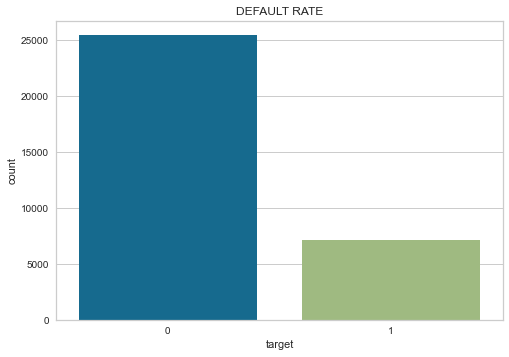

In [74]:
sns.countplot(data=df, x="target").set_title("DEFAULT RATE");

    The target variable distribution is slightly imbalanced with a percentage of 22 % for the minority class. 

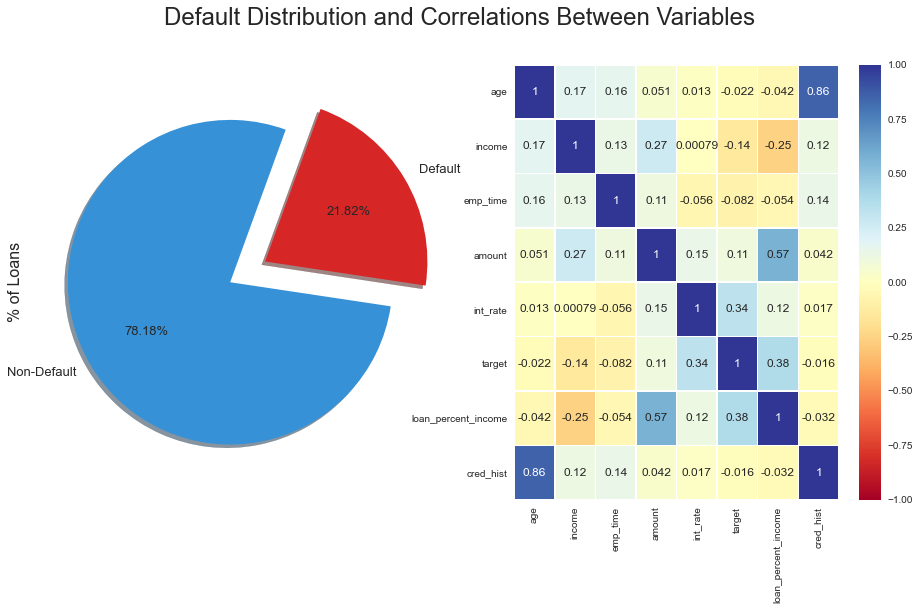

In [8]:
# This visualisation was inspred by Janio Martinez Bachmann's kaggle notebook (look references)

f, ax = plt.subplots(1,2, figsize=(16,8))

colors = ["#3791D7", "#D72626"]
labels =["Non-Default", "Default"]

plt.suptitle('Default Distribution and Correlations Between Variables', fontsize=24)

df["target"].value_counts().plot.pie(explode=[0,0.25], 
                                     autopct='%1.2f%%', 
                                     ax=ax[0], 
                                     shadow=True, 
                                     colors=colors, 
                                     labels=labels, 
                                     fontsize=13, 
                                     startangle=70)


ax[0].set_ylabel('% of Loans', fontsize=16)


sns.heatmap(df.corr(), 
            annot=True, 
            cmap="RdYlBu", 
            vmin= -1, 
            vmax=1,
            linewidth=0.5);

    Our main aim is classifying to defaulted loans. Therefore, we especially interested in minority class of the 
    target variable which is slightly imbalanced as we mentioned before.   
    
    Correlations:
    
    1. "Cred_hist" and "age" have multicollinearity which this is quite meaningful logically.
    2. "loan_percent_income" correlated with "income" and "amount" because of that it is a generated feature from the division of amount to income.
    3. "amount" and "income" have positive correlation. 
    
    
    
### Choose of Metrics:
    
    Most important metric is Recall Score. Because costs of defaulted loans are under liability of the bank. But we can 
    not waived off Precision Score. Therefore, We'll decide a score for precision and try to maximize recall score 
    under this condition.
    
    
    Min. Precision Score: %80 
    Min. Recall Score: %80
    
    Goal: Maximize Recall 
    


    

# Statistics of Data

In [76]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,32581.0,27.734600,6.348078,20.00,23.00,26.00,30.00,144.00
income,32581.0,66074.848470,61983.119168,4000.00,38500.00,55000.00,79200.00,6000000.00
emp_time,31686.0,4.789686,4.142630,0.00,2.00,4.00,7.00,123.00
amount,32581.0,9589.371106,6322.086646,500.00,5000.00,8000.00,12200.00,35000.00
int_rate,29465.0,11.011695,3.240459,5.42,7.90,10.99,13.47,23.22
target,32581.0,0.218164,0.413006,0.00,0.00,0.00,0.00,1.00
loan_percent_income,32581.0,0.170203,0.106782,0.00,0.09,0.15,0.23,0.83
cred_hist,32581.0,5.804211,4.055001,2.00,3.00,4.00,8.00,30.00


    1. %75 of age of customer are under 30. 
    2. "emp_time" and "age" max values are inlogical.
    3. %75 of income of customer are under 79.200 $ but max value is 6 million. There are huge jumping in last 
    quantile.  
    

In [9]:
df[df["age"] > 94]

,age,income,ownership,emp_time,intent,grade,amount,int_rate,target,loan_percent_income,default_on_file,cred_hist
81,144,250000,RENT,4.0,VENTURE,C,4800,13.57,0,0.02,N,3
183,144,200000,MORTGAGE,4.0,EDUCATION,B,6000,11.86,0,0.03,N,2
575,123,80004,RENT,2.0,EDUCATION,B,20400,10.25,0,0.25,N,3
747,123,78000,RENT,7.0,VENTURE,B,20000,NaN,0,0.26,N,4
32297,144,6000000,MORTGAGE,12.0,PERSONAL,C,5000,12.73,0,0.00,N,25


In [205]:
outlier_index_age = df[df["age"] > 94].index
df.drop(index= outlier_index_age, inplace=True) 

In [206]:
df[df["emp_time"]>50]

,age,income,ownership,emp_time,intent,grade,amount,int_rate,target,loan_percent_income,default_on_file,cred_hist
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
210,21,192000,MORTGAGE,123.0,VENTURE,A,20000,6.54,0,0.10,N,4


In [207]:
df.loc[0, "emp_time"]= df[df["age"]==22]["emp_time"].median()
df.loc[210, "emp_time"]= np.nan

# Structure of Data

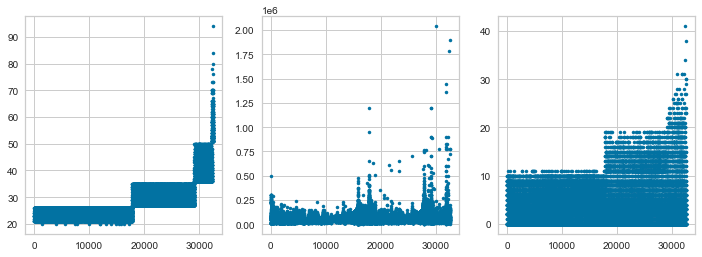

In [80]:
fig, ax = plt.subplots(1,3, figsize=(12,4))

plt.subplot(1, 3,1)
plt.plot(df["age"],".")

plt.subplot(1,3,2)
plt.plot(df["income"],".")

plt.subplot(1,3,3)
plt.plot(df["emp_time"],".");


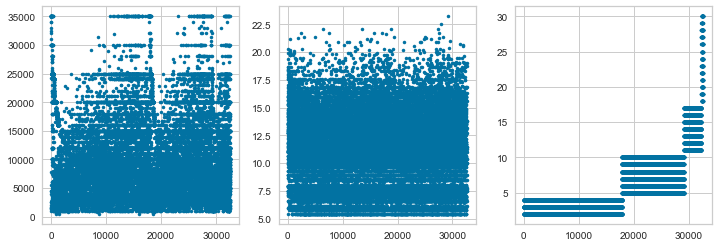

In [81]:
fig, ax = plt.subplots(2,3, figsize=(12,4))

plt.subplot(1, 3,1)
plt.plot(df["amount"],".")

plt.subplot(1, 3,2)
plt.plot(df["int_rate"],".")

plt.subplot(1, 3,3)
plt.plot(df["cred_hist"],".");

    1. Vertical lines tell that the data is not sufficiently shuffled.  
    
    2. Horizontal lines show that there are many repetitive values. This information could be usefull for
    discretization process. 

In [208]:
# Shuffle Data and Reset index
df = df.sample(frac=1, random_state=123).reset_index(drop=True)

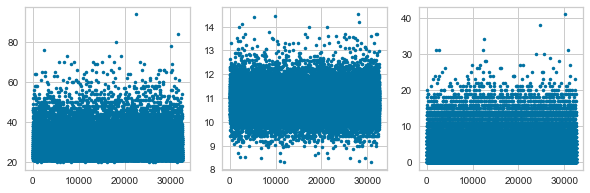

In [83]:
fig, ax = plt.subplots(2,3, figsize=(10,3))

plt.subplot(1, 3,1)
plt.plot(df["age"],".")

plt.subplot(1,3,2)
plt.plot(np.log(df["income"]),".")

plt.subplot(1,3,3)
plt.plot(df["emp_time"],".");

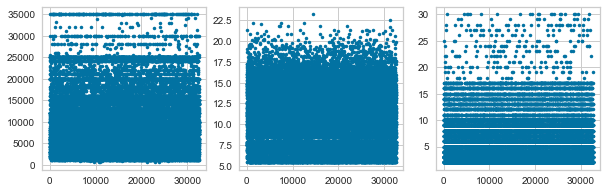

In [84]:
fig, ax = plt.subplots(2,3, figsize=(10,3))

plt.subplot(1, 3,1)
plt.plot(df["amount"],".")

plt.subplot(1, 3,2)
plt.plot(df["int_rate"],".")

plt.subplot(1, 3,3)
plt.plot(df["cred_hist"],".");

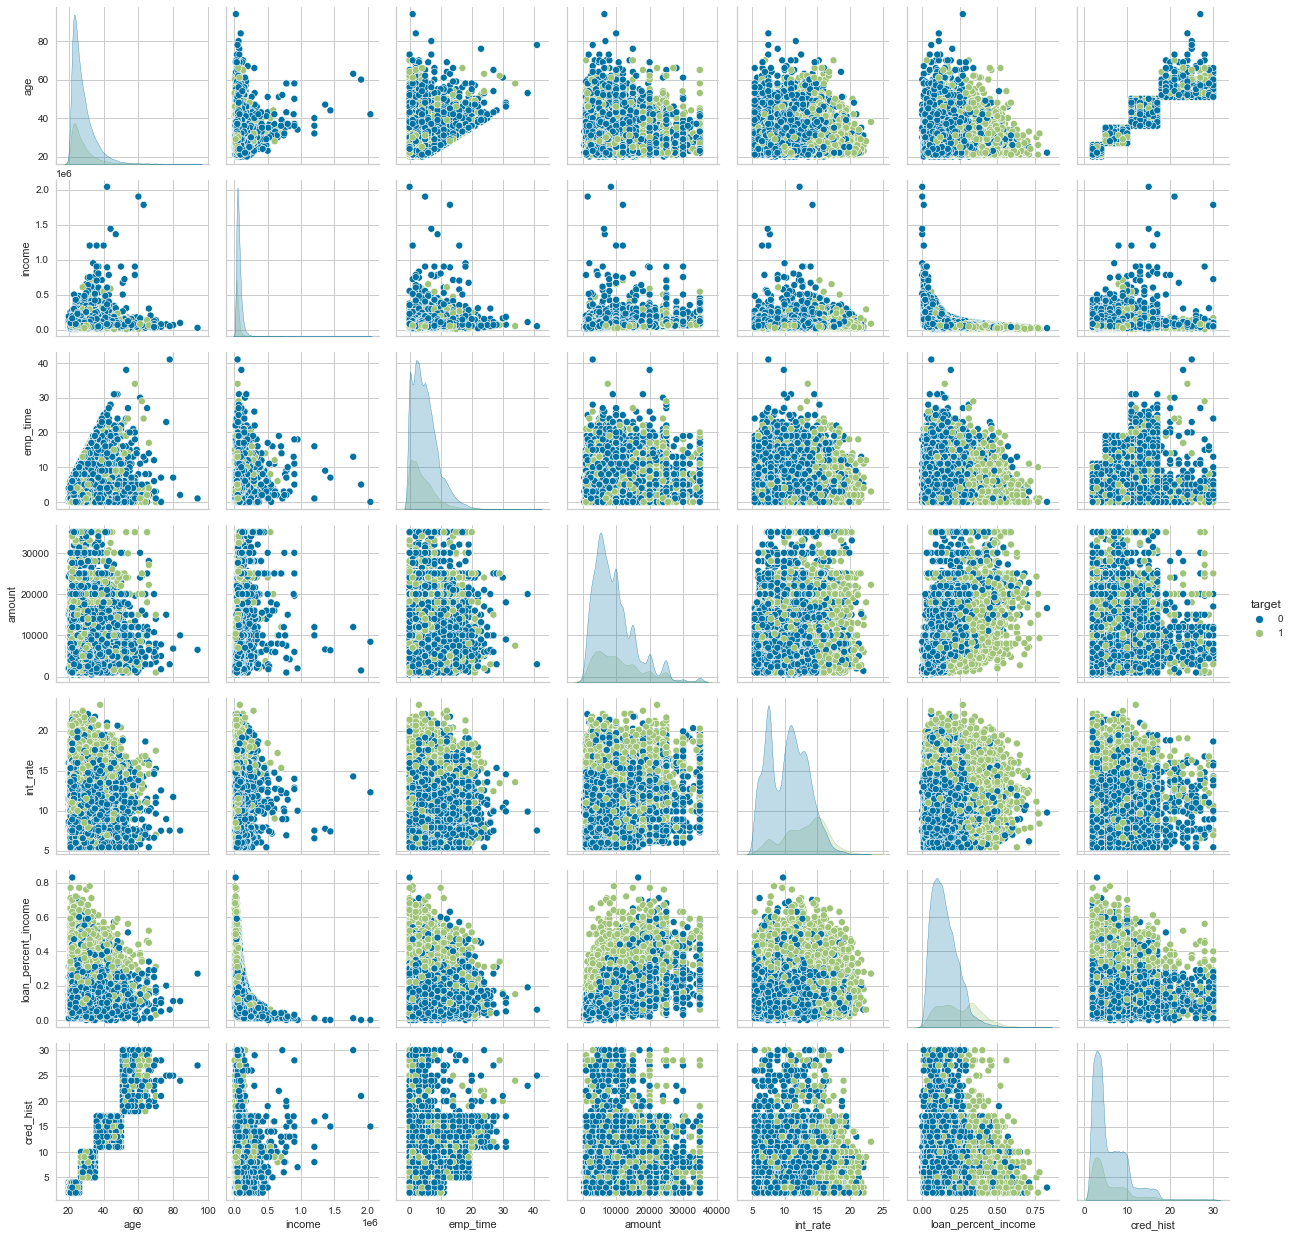

In [85]:
sns.pairplot(df, hue="target", diag_kind="kde");

In [10]:
cross_types = pd.crosstab(df['ownership'], df['grade'],values=df['target'], aggfunc='mean')


cross_types.style.highlight_max(axis=0)
cm = sns.light_palette("seagreen", as_cmap=True)

cross_types.style.background_gradient(cmap=cm)

grade,A,B,C,D,E,F,G
ownership,,,,,,,
MORTGAGE,0.043789,0.079941,0.142350,0.456647,0.474926,0.628866,1.000000
OTHER,0.115385,0.147059,0.352941,0.550000,0.750000,1.000000,nan
OWN,0.071274,0.042289,0.062626,0.063830,0.543860,0.533333,1.000000
RENT,0.175177,0.240647,0.265782,0.737814,0.755357,0.779528,0.964286


In [11]:
cross_types2= pd.crosstab(df['ownership'], df['grade'],
                          values=df['income'], aggfunc='mean').round(2)

cross_types2.style.highlight_min(axis=0)


grade,A,B,C,D,E,F,G
ownership,,,,,,,
MORTGAGE,77673.920000,82607.670000,83705.230000,82166.940000,93852.230000,93995.670000,87966.190000
OTHER,71390.620000,68493.030000,56471.590000,124495.650000,49174.500000,72625.000000,nan
OWN,56178.460000,61593.220000,53405.100000,58003.000000,54808.930000,108242.330000,72568.000000
RENT,54862.360000,55182.700000,55029.810000,53238.800000,58907.610000,60414.480000,65132.110000


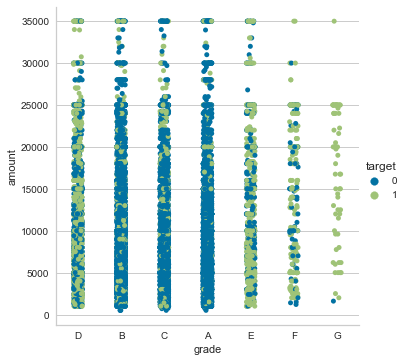

In [12]:
sns.catplot(x="grade", y="amount", hue="target", data=df)

# MISSING VALUE DETECTION


In [88]:
df.isna().sum().sort_values(ascending=False)

int_rate               3115
emp_time                896
age                       0
income                    0
ownership                 0
intent                    0
grade                     0
amount                    0
target                    0
loan_percent_income       0
default_on_file           0
cred_hist                 0
dtype: int64

In [89]:
print("Interest Rates missing values:  % {}".format(np.round((df["int_rate"].isna().sum()/len(df["int_rate"]) * 100), 2)))
print("Employee time missing values:   % {}".format(np.round((df["emp_time"].isna().sum()/len(df["emp_time"]) * 100), 2)))

Interest Rates missing values:  % 9.56
Employee time missing values:   % 2.75


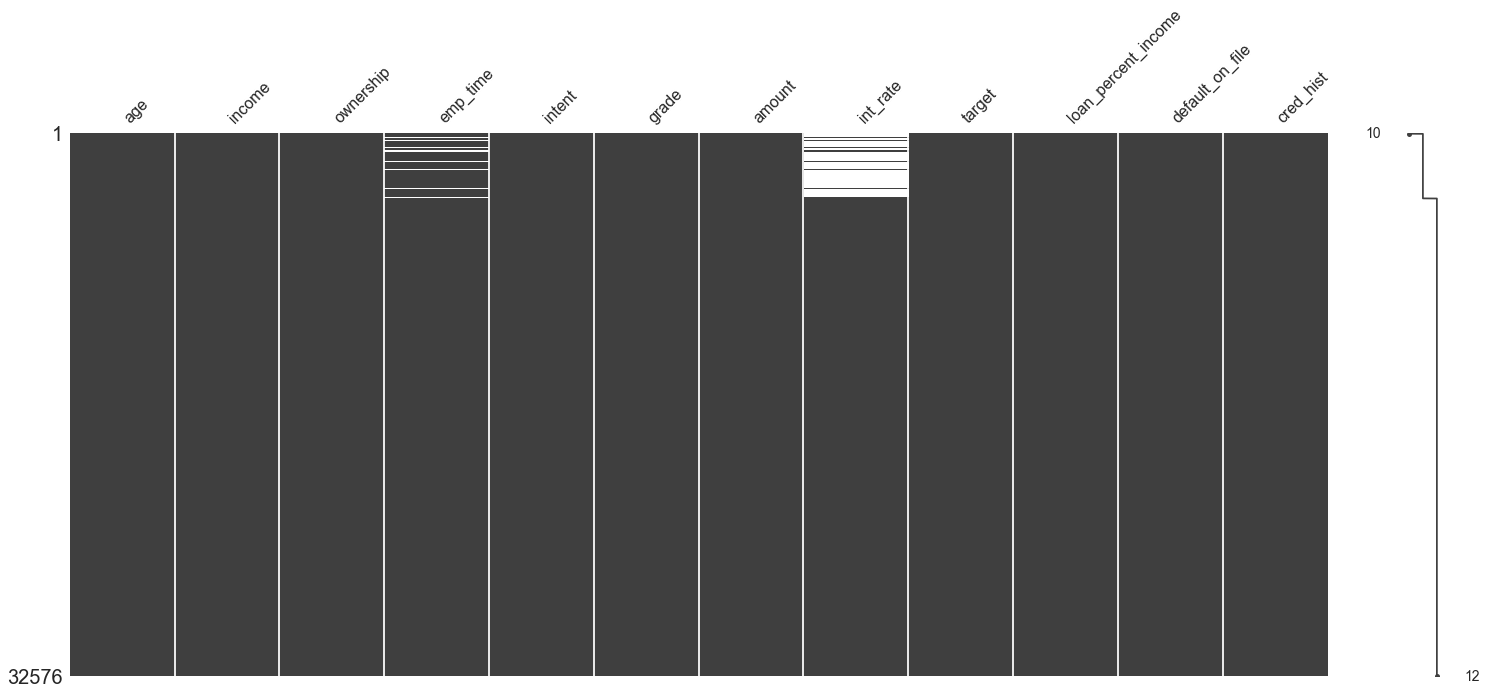

In [90]:
msno.matrix(df, sort="ascending");

In [91]:
df["joint_missing"] = np.where(df["int_rate"].isna() & df["emp_time"].isna(), 1, 0)

In [92]:
print("Sum of Joint Missing Value: ", df["joint_missing"].sum())
print("Rate of Joint Missing %", np.round(df["joint_missing"].sum() / df["emp_time"].isna().sum(),2) * 100)
del df["joint_missing"]

Sum of Joint Missing Value:  68
Rate of Joint Missing % 8.0


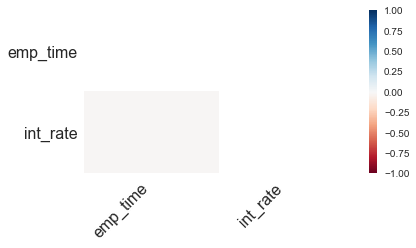

In [93]:
msno.heatmap(df, figsize=(6, 3));

###### Missing Value Analysis: 

    There are missing values only in 2 features: "int_rate" and "emp_time". The proportion of missingness is about %10 for "int_rate" and it is under %5 for "emp_time". Missingness are clustering around same values. Obviously, they    are not completely at random(MCAR). The correlation was investigated. There is no correlation between missing 
    values and joint missing values are only %8.   


###### Missing Value Strategy:
    Firstly, I'll use arbitrary imputation for emp_time. After that, I'll discretize "emp_time" and arbitrary values in feature are labeled as "Missing".  

    Median imputation for int_rate would be violation of assumption(because of missingness type) without adding a 
    binary variable that represent missingness in data. So, I'll add a new feature and fill NA values with median of 
    training set.  

# Distributions

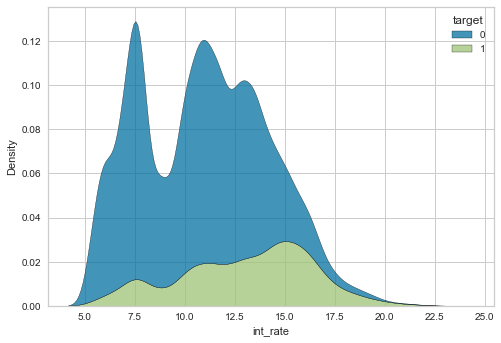

In [94]:
sns.kdeplot(data= df, x= "int_rate", multiple="stack", hue="target", color="#DF3A01");

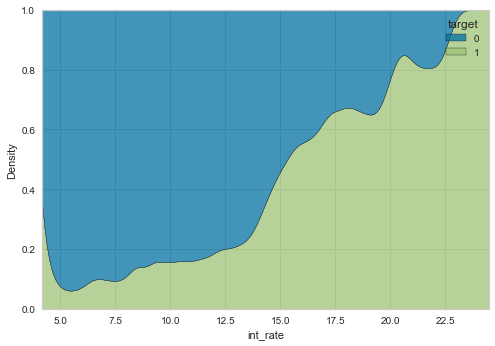

In [95]:
sns.kdeplot(data= df, x= "int_rate", multiple="fill", hue="target", color="#DF3A01");

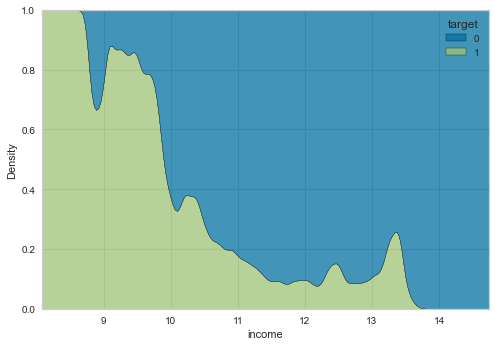

In [96]:
log_income = np.around(np.log(df["income"]),3)
sns.kdeplot(data= df, x= log_income, multiple="fill", hue="target", color="#DF3A01");


    According to visualizations, low income and high interest rates related with default status. 

    logarithmic transformation was used for visualize income distribution because there was outliers that had distorted   
    the distribution of data.

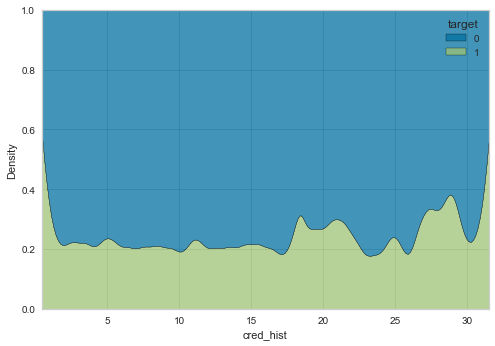

In [97]:
sns.kdeplot(data= df, x= "cred_hist", multiple="fill", hue="target", color="#DF3A01");


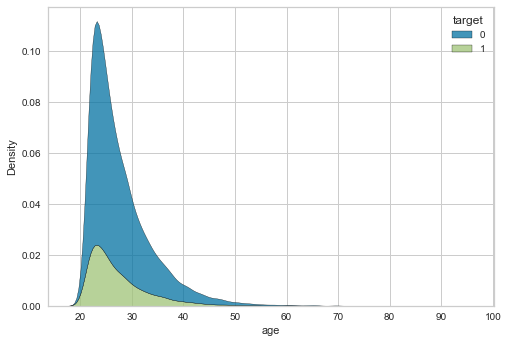

In [98]:
sns.kdeplot(data= df, x= "age", multiple="stack", hue="target", color="#DF3A01");


    "Cred History" and "age" data seem quite monotone.  

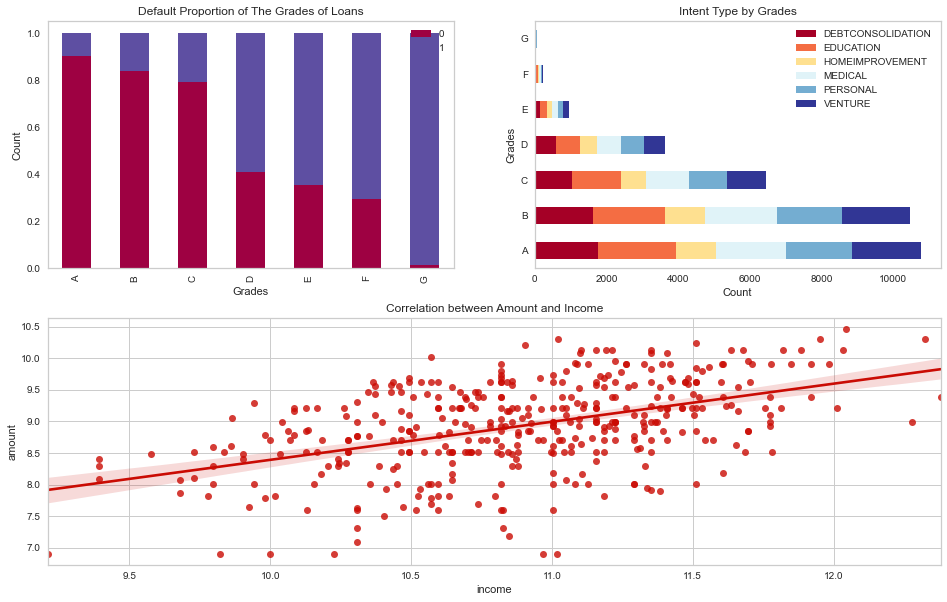

In [99]:
# This visualisation was inspred by Janio Martinez Bachmann's kaggle notebook (look references)

fig = plt.figure(figsize=(16,8))

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(212)


grades = df.loc[(df['grade'] == 'A') | 
                (df['grade'] == 'B') | 
                (df['grade'] == 'C') | 
                (df['grade'] == 'D') | 
                (df['grade'] == 'E') | 
                (df['grade'] == 'F') | 
                (df['grade'] == 'G') ]

grade_target = grades.groupby(['grade'])['target'].value_counts(normalize=True)
grade_target.unstack().plot(kind='bar', 
                            stacked=True, 
                            colormap='Spectral', 
                            figsize=(16,10), 
                            grid=False, 
                            ax=ax1)
ax1.set_xlabel("Grades")
ax1.set_ylabel("Count")
ax1.set_title("Default Proportion of The Grades of Loans")
ax1.legend(loc="best", prop={'size': 10})

grade_income = grades.groupby(['grade','intent']).size()
grade_income.unstack().plot(kind='barh', 
                            stacked=True, 
                            colormap='RdYlBu', 
                            figsize=(16,10), 
                            grid=False, 
                            ax=ax2)
ax2.set_xlabel("Count")
ax2.set_ylabel("Grades")
ax2.set_title("Intent Type by Grades")
ax2.legend(loc="best", prop={'size': 10})



sample = grades.sample(frac=1)
sample = sample[:400]
sns.regplot(x=np.log(sample["income"]), 
            y=np.log(sample["amount"]), 
            color="r", 
            ax=ax3)

ax3.set_title("Correlation between Amount and Income");

# -----------------------------   FEATURE ENGINEERING  --------------------------------



    Emp_time: Discretization + Weight of Evidence(WOE) encoding 
    Grade: Mean Encoding 
    Ownership: WOE encoding
    Intent: WOE encoding 
   

In [209]:
# Flag for missing values
df["emp_time"].fillna(99, inplace=True) 

# adding binary variable represents missingness 
df["int_missing"] = np.where(df["int_rate"].isna(), 1, 0)


# encoding for default_on_file
default_map = {"Y":1, "N":0}
df["default_on_file"] = df["default_on_file"].map(default_map)


In [210]:
df["emp_time"].isna().sum()

0

# Discretization of emp_time

In [211]:
buckets = [0, 2, 5, 8, 45, 999]
labels = ["Entry", "Jr", "Mid", "Experienced", "Missing"]

# discretisation
df['emp_time'] = pd.cut(df['emp_time'], 
                        bins=buckets, 
                        labels=labels, 
                        include_lowest=True)


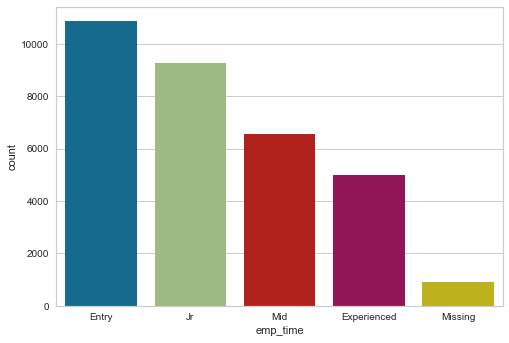

In [212]:
sns.countplot(data= df, x= "emp_time")

# Splitting the Data

In [213]:
X = df
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size= 0.2, 
                                                    random_state=42, 
                                                    stratify=y, shuffle=True)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                test_size=0.25, 
                                                random_state=42,
                                                stratify=y_train, shuffle=True)

# WOE Encoding for Emp_Time

In [214]:
emp_time_crosstab = pd.crosstab(X_train["emp_time"], X_train["target"])
emp_time_crosstab

target,0,1
emp_time,,
Entry,4730,1748
Jr,4478,1114
Mid,3213,720
Experienced,2493,524
Missing,366,159


In [215]:
ratio_event_emptime = emp_time_crosstab[1] / emp_time_crosstab[1].sum()
ratio_non_event_emptime = emp_time_crosstab[0] / emp_time_crosstab[0].sum()

In [216]:
woe_emptime = np.log(ratio_event_emptime/ratio_non_event_emptime)
woe_emptime

emp_time
Entry          0.280650
Jr            -0.115117
Mid           -0.219607
Experienced   -0.283648
Missing        0.442373
dtype: float64

In [217]:
emp_time_mapping = {"Entry":0.28, "Jr": -0.11, "Mid": -0.22, "Experienced":-0.28, "Missing": 0.44}

X_train["emp_time"] = X_train["emp_time"].map(emp_time_mapping)
X_val["emp_time"] = X_val["emp_time"].map(emp_time_mapping)
X_test["emp_time"] = X_test["emp_time"].map(emp_time_mapping)


In [218]:
X_train["emp_time"] = X_train["emp_time"].astype("float")
X_val["emp_time"] = X_val["emp_time"].astype("float")
X_test["emp_time"] = X_test["emp_time"].astype("float")

# Mean Encoding for Grades

In [219]:
X_train.groupby("grade")["target"].mean()

grade
A    0.100873
B    0.161131
C    0.209895
D    0.575730
E    0.666667
F    0.716216
G    0.975610
Name: target, dtype: float64

In [220]:
grade_mapping = {"A": 0.10, "B": 0.16, "C":0.2, "D": 0.57, "E": 0.66, "F": 0.71, "G": 0.97}

X_train["grade"] = X_train["grade"].map(grade_mapping)
X_val["grade"] = X_val["grade"].map(grade_mapping)
X_test["grade"] = X_test["grade"].map(grade_mapping)


# WOE Encoding for Ownership

In [221]:
ownership_crosstab = pd.crosstab(X_train["ownership"], X_train["target"])
ownership_crosstab

target,0,1
ownership,,
MORTGAGE,6984,1020
OTHER,47,22
OWN,1474,116
RENT,6775,3107


In [222]:
ratio_event_ownership = ownership_crosstab[1] / ownership_crosstab[1].sum()
ratio_non_event_ownership = ownership_crosstab[0] / ownership_crosstab[0].sum()
woe_ownership = np.log(ratio_event_ownership/ratio_non_event_ownership)
woe_ownership

ownership
MORTGAGE   -0.647717
OTHER       0.516997
OWN        -1.266042
RENT        0.496521
dtype: float64

In [223]:
ownership_map = {"OWN": -1.26, "MORTGAGE":-0.64, "OTHER":0.51, "RENT":0.5}

X_train["ownership"] = X_train["ownership"].map(ownership_map)
X_val["ownership"] = X_val["ownership"].map(ownership_map)
X_test["ownership"] = X_test["ownership"].map(ownership_map)

# WOE Encoding for İntent

In [224]:
intent_crosstab = pd.crosstab(X_train["intent"], X_train["target"])
intent_crosstab

target,0,1
intent,,
DEBTCONSOLIDATION,2224,902
EDUCATION,3178,673
HOMEIMPROVEMENT,1618,557
MEDICAL,2696,970
PERSONAL,2637,654
VENTURE,2927,509


In [225]:
ratio_event_intent = intent_crosstab[1] / intent_crosstab[1].sum()
ratio_non_event_intent = intent_crosstab[0] / intent_crosstab[0].sum()
woe_intent = np.log(ratio_event_intent/ratio_non_event_intent)
woe_intent

intent
DEBTCONSOLIDATION    0.373654
EDUCATION           -0.276159
HOMEIMPROVEMENT      0.209722
MEDICAL              0.253874
PERSONAL            -0.118187
VENTURE             -0.473183
dtype: float64

In [226]:
intent_map = {"DEBTCONSOLIDATION": 0.37, "EDUCATION": -0.27, "HOMEIMPROVEMENT":0.20, "MEDICAL": 0.25,
             "PERSONAL": -0.12, "VENTURE": -0.47}

X_train["intent"] = X_train["intent"].map(intent_map)
X_val["intent"] = X_val["intent"].map(intent_map)
X_test["intent"] = X_test["intent"].map(intent_map)

# Feature Generation: intloan_percent_income

In [227]:
X_train["int_rate"].fillna(X_train["int_rate"].median(), inplace=True)
X_val["int_rate"].fillna(X_val["int_rate"].median(), inplace=True)
X_test["int_rate"].fillna(X_test["int_rate"].median(), inplace=True)

In [228]:
X_train["interestt"] = ((X_train["int_rate"] / 100) + 1)
X_val["interestt"] = ((X_val["int_rate"] / 100) + 1)
X_test["interestt"] = ((X_test["int_rate"] / 100) + 1)

In [229]:
X_train["intloan_percent_income"] = ((X_train["amount"] * X_train["interestt"]) / X_train["income"])
X_val["intloan_percent_income"] = ((X_val["amount"] * X_val["interestt"]) / X_val["income"])
X_test["intloan_percent_income"] = ((X_test["amount"] * X_test["interestt"]) / X_test["income"])

In [230]:
del X_train["interestt"]
del X_val["interestt"]
del X_test["interestt"]

del X_train["loan_percent_income"]
del X_val["loan_percent_income"]
del X_test["loan_percent_income"]

# HANDLING OUTLIERS

In [231]:
# this function take a columns list as an input and winsorize it. 

def winsorize(column_list):
    for i in column_list:
        lower_boundary, upper_boundary = np.percentile(X_train[i], [1.5, 98.5])
        X_train[i] = np.clip(X_train[i], lower_boundary, upper_boundary)
        X_val[i] = np.clip(X_val[i], lower_boundary, upper_boundary)
        X_test[i] = np.clip(X_test[i], lower_boundary, upper_boundary)
        

In [232]:
column_list= ["age","income", "cred_hist","int_rate","amount"]

In [233]:
winsorize(column_list)

In [234]:
# Drop the target

X_train.drop("target", axis=1, inplace=True)
X_val.drop("target", axis=1, inplace=True)
X_test.drop("target", axis=1, inplace=True)

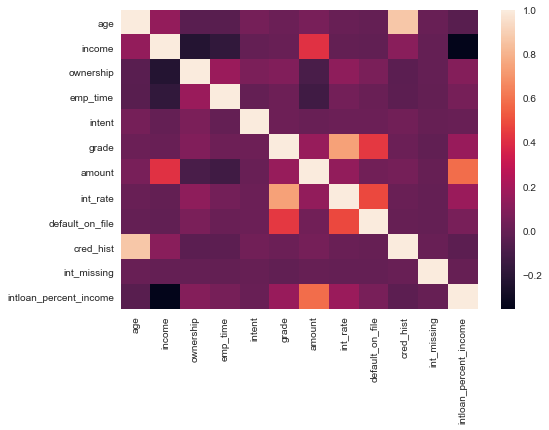

In [235]:
# Final situation
sns.heatmap(X_train.corr())

# DECISION TREE 

In [127]:
param_grid = {"max_depth": [2, 3, 4],
              "max_features": [8,9,10,11,12],
              "splitter": ["best","random"],
             "criterion": ["gini", "entropy"],
             "min_samples_split": [0.1, 0.4, 0.8, 2, 3, 4, 5,  7, 10, 20]}

dc = DecisionTreeClassifier()

dc_cv = GridSearchCV(dc, 
                     param_grid,
                     cv=5, 
                     n_jobs=-1, 
                     scoring="f1", 
                     verbose=3)

dc_cv.fit(X_train, y_train)

cv_result = pd.DataFrame(dc_cv.cv_results_)

Fitting 5 folds for each of 600 candidates, totalling 3000 fits


In [128]:
dc_cv.best_params_

{'criterion': 'gini',
 'max_depth': 4,
 'max_features': 11,
 'min_samples_split': 3,
 'splitter': 'best'}

In [129]:
dc = DecisionTreeClassifier(max_depth=4, 
                            criterion="gini",
                            min_samples_split=3,
                            max_features=11)
dc.fit(X_train, y_train)

y_pred_train = dc.predict(X_train)
y_pred_val = dc.predict(X_val)
y_pred_test = dc.predict(X_test)
print("Train Score: \n", classification_report(y_train, y_pred_train))
print("Validation Score: \n", classification_report(y_val, y_pred_val))
print("Test Score: \n", classification_report(y_test, y_pred_test))
print("train roc: ",roc_auc_score(y_train, y_pred_train))
print("val roc: ",roc_auc_score(y_val, y_pred_val))
print("Test roc: ", roc_auc_score(y_test, y_pred_test))

Train Score: 
               precision    recall  f1-score   support

           0       0.92      0.98      0.95     15280
           1       0.90      0.69      0.78      4265

    accuracy                           0.92     19545
   macro avg       0.91      0.83      0.86     19545
weighted avg       0.91      0.92      0.91     19545

Validation Score: 
               precision    recall  f1-score   support

           0       0.92      0.98      0.95      5094
           1       0.90      0.68      0.77      1421

    accuracy                           0.91      6515
   macro avg       0.91      0.83      0.86      6515
weighted avg       0.91      0.91      0.91      6515

Test Score: 
               precision    recall  f1-score   support

           0       0.92      0.98      0.95      5094
           1       0.90      0.70      0.79      1422

    accuracy                           0.92      6516
   macro avg       0.91      0.84      0.87      6516
weighted avg       0.92  

In [130]:
classifier = DecisionTreeClassifier(max_depth=4, 
                            criterion="gini",
                            min_samples_split=3,
                            max_features=11) 

classifier.fit(X_train, y_train)

viz = dtreeviz(classifier, 
               X_train, 
               y_train,
               feature_names=X_train.columns,
               class_names=["Non-Default","Default"]) 
              
viz.view()

In [131]:
drawing = svg2rlg("file:///C:/Users/hp/AppData/Local/Temp/DTreeViz_8972.svg")


In [132]:
renderPDF.drawToFile(drawing, "C:\\Users\\hp\\Desktop\\CreditRisk\\tree_model.pdf")


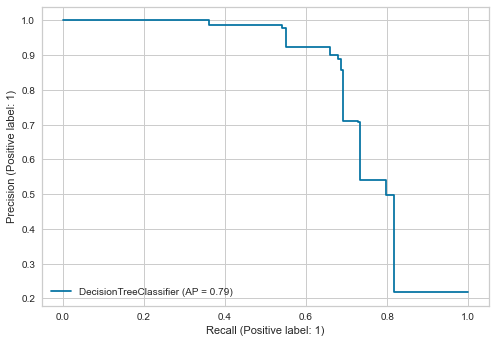

In [133]:
dc_disp = plot_precision_recall_curve(dc, X_val, y_val)

# Simple Tuning Before Recursive Elimination

In [175]:
param_grid = {"max_depth": [4, 5, 6, 7, 8],
              "learning_rate": [0.01, 0.05, 0.1, 0.15, 0.2],
              "subsample": [0.6, 0.8, 0.9, 1.0],
             "colsample_bytree": [0.6, 0.8, 0.9, 1.0]}

eval_set = [(X_train, y_train), (X_val, y_val)]

fit_params = {"eval_set":eval_set, "eval_metric":"aucpr", "early_stopping_rounds":50, "verbose":True}


xgb = XGBClassifier(n_estimators=1000)

xgb_cv = GridSearchCV(xgb,
                      param_grid,
                      cv=3, 
                      n_jobs=-1, 
                      scoring="f1", 
                      verbose=3)

xgb_cv.fit(X_train, y_train, **fit_params)
cv_result = pd.DataFrame(xgb_cv.cv_results_)

Fitting 3 folds for each of 400 candidates, totalling 1200 fits
[0]	validation_0-aucpr:0.850036	validation_1-aucpr:0.835042
Multiple eval metrics have been passed: 'validation_1-aucpr' will be used for early stopping.

Will train until validation_1-aucpr hasn't improved in 50 rounds.
[1]	validation_0-aucpr:0.856717	validation_1-aucpr:0.839171
[2]	validation_0-aucpr:0.860702	validation_1-aucpr:0.844674
[3]	validation_0-aucpr:0.860343	validation_1-aucpr:0.842926
[4]	validation_0-aucpr:0.860393	validation_1-aucpr:0.844359
[5]	validation_0-aucpr:0.861267	validation_1-aucpr:0.845326
[6]	validation_0-aucpr:0.861287	validation_1-aucpr:0.84494
[7]	validation_0-aucpr:0.861929	validation_1-aucpr:0.845928
[8]	validation_0-aucpr:0.86343	validation_1-aucpr:0.846886
[9]	validation_0-aucpr:0.86386	validation_1-aucpr:0.847214
[10]	validation_0-aucpr:0.863653	validation_1-aucpr:0.846925
[11]	validation_0-aucpr:0.864059	validation_1-aucpr:0.847228
[12]	validation_0-aucpr:0.864834	validation_1-aucpr:0.84

[131]	validation_0-aucpr:0.937298	validation_1-aucpr:0.89254
[132]	validation_0-aucpr:0.937306	validation_1-aucpr:0.892536
[133]	validation_0-aucpr:0.937478	validation_1-aucpr:0.892532
[134]	validation_0-aucpr:0.93774	validation_1-aucpr:0.892573
[135]	validation_0-aucpr:0.937997	validation_1-aucpr:0.892568
[136]	validation_0-aucpr:0.938106	validation_1-aucpr:0.892525
[137]	validation_0-aucpr:0.938267	validation_1-aucpr:0.89253
[138]	validation_0-aucpr:0.938289	validation_1-aucpr:0.892546
[139]	validation_0-aucpr:0.938544	validation_1-aucpr:0.892516
[140]	validation_0-aucpr:0.939435	validation_1-aucpr:0.892926
[141]	validation_0-aucpr:0.939693	validation_1-aucpr:0.89289
[142]	validation_0-aucpr:0.940012	validation_1-aucpr:0.89294
[143]	validation_0-aucpr:0.940324	validation_1-aucpr:0.893009
[144]	validation_0-aucpr:0.940835	validation_1-aucpr:0.893483
[145]	validation_0-aucpr:0.941352	validation_1-aucpr:0.893479
[146]	validation_0-aucpr:0.941771	validation_1-aucpr:0.893798
[147]	validat

[264]	validation_0-aucpr:0.965487	validation_1-aucpr:0.896755
[265]	validation_0-aucpr:0.965559	validation_1-aucpr:0.896783
[266]	validation_0-aucpr:0.965749	validation_1-aucpr:0.896862
[267]	validation_0-aucpr:0.966118	validation_1-aucpr:0.896899
[268]	validation_0-aucpr:0.966332	validation_1-aucpr:0.896815
[269]	validation_0-aucpr:0.966472	validation_1-aucpr:0.89683
[270]	validation_0-aucpr:0.966737	validation_1-aucpr:0.896787
[271]	validation_0-aucpr:0.966839	validation_1-aucpr:0.896795
[272]	validation_0-aucpr:0.966879	validation_1-aucpr:0.896797
[273]	validation_0-aucpr:0.966997	validation_1-aucpr:0.896845
[274]	validation_0-aucpr:0.967213	validation_1-aucpr:0.896891
[275]	validation_0-aucpr:0.967503	validation_1-aucpr:0.896845
[276]	validation_0-aucpr:0.96754	validation_1-aucpr:0.896884
[277]	validation_0-aucpr:0.967581	validation_1-aucpr:0.8969
[278]	validation_0-aucpr:0.967636	validation_1-aucpr:0.896874
[279]	validation_0-aucpr:0.967827	validation_1-aucpr:0.896887
[280]	valida

[397]	validation_0-aucpr:0.980057	validation_1-aucpr:0.898022
[398]	validation_0-aucpr:0.9802	validation_1-aucpr:0.898034
[399]	validation_0-aucpr:0.980237	validation_1-aucpr:0.898033
[400]	validation_0-aucpr:0.980252	validation_1-aucpr:0.898009
[401]	validation_0-aucpr:0.980254	validation_1-aucpr:0.898006
[402]	validation_0-aucpr:0.980405	validation_1-aucpr:0.89806
[403]	validation_0-aucpr:0.980451	validation_1-aucpr:0.898053
[404]	validation_0-aucpr:0.980528	validation_1-aucpr:0.898009
[405]	validation_0-aucpr:0.980568	validation_1-aucpr:0.89796
[406]	validation_0-aucpr:0.980571	validation_1-aucpr:0.897941
[407]	validation_0-aucpr:0.980577	validation_1-aucpr:0.897941
[408]	validation_0-aucpr:0.980636	validation_1-aucpr:0.897971
[409]	validation_0-aucpr:0.980695	validation_1-aucpr:0.89796
[410]	validation_0-aucpr:0.980739	validation_1-aucpr:0.897936
[411]	validation_0-aucpr:0.980763	validation_1-aucpr:0.897972
[412]	validation_0-aucpr:0.980785	validation_1-aucpr:0.897974
[413]	validat

[530]	validation_0-aucpr:0.98778	validation_1-aucpr:0.898538
[531]	validation_0-aucpr:0.987854	validation_1-aucpr:0.898437
[532]	validation_0-aucpr:0.987883	validation_1-aucpr:0.898389
[533]	validation_0-aucpr:0.987895	validation_1-aucpr:0.898409
[534]	validation_0-aucpr:0.987906	validation_1-aucpr:0.898394
[535]	validation_0-aucpr:0.988001	validation_1-aucpr:0.898398
[536]	validation_0-aucpr:0.988137	validation_1-aucpr:0.898258
[537]	validation_0-aucpr:0.988161	validation_1-aucpr:0.898246
[538]	validation_0-aucpr:0.988187	validation_1-aucpr:0.898216
[539]	validation_0-aucpr:0.988209	validation_1-aucpr:0.898219
[540]	validation_0-aucpr:0.988277	validation_1-aucpr:0.89822
[541]	validation_0-aucpr:0.988284	validation_1-aucpr:0.898232
[542]	validation_0-aucpr:0.988323	validation_1-aucpr:0.898169
[543]	validation_0-aucpr:0.988342	validation_1-aucpr:0.898139
[544]	validation_0-aucpr:0.988458	validation_1-aucpr:0.898044
[545]	validation_0-aucpr:0.988504	validation_1-aucpr:0.898068
[546]	vali

In [176]:
xgb_cv.best_params_

{'colsample_bytree': 1.0,
 'learning_rate': 0.1,
 'max_depth': 5,
 'subsample': 1.0}

# Recursive Elimination

In [177]:
xgb = XGBClassifier(n_estimators=1000,
                   learning_rate=0.1,
                   max_depth=5)


xgb.fit(X_train, y_train, early_stopping_rounds=50, eval_metric="aucpr", eval_set=eval_set, verbose=False)

y_pred_train = xgb.predict(X_train)
y_pred_val = xgb.predict(X_val)
y_pred_test = xgb.predict(X_test)

print("Train Score: \n", classification_report(y_train, y_pred_train))
print("Validation Score: \n", classification_report(y_val, y_pred_val))
print("Test Score: \n", classification_report(y_test, y_pred_test))
print("train roc: ",roc_auc_score(y_train, y_pred_train))
print("val roc: ",roc_auc_score(y_val, y_pred_val))
print("Test roc: ", roc_auc_score(y_test, y_pred_test))

Train Score: 
               precision    recall  f1-score   support

           0       0.96      1.00      0.98     15280
           1       0.99      0.84      0.91      4265

    accuracy                           0.96     19545
   macro avg       0.98      0.92      0.95     19545
weighted avg       0.97      0.96      0.96     19545

Validation Score: 
               precision    recall  f1-score   support

           0       0.93      0.99      0.96      5094
           1       0.94      0.73      0.83      1421

    accuracy                           0.93      6515
   macro avg       0.94      0.86      0.89      6515
weighted avg       0.93      0.93      0.93      6515

Test Score: 
               precision    recall  f1-score   support

           0       0.94      0.99      0.96      5094
           1       0.95      0.76      0.84      1422

    accuracy                           0.94      6516
   macro avg       0.94      0.87      0.90      6516
weighted avg       0.94  

<BarContainer object of 12 artists>

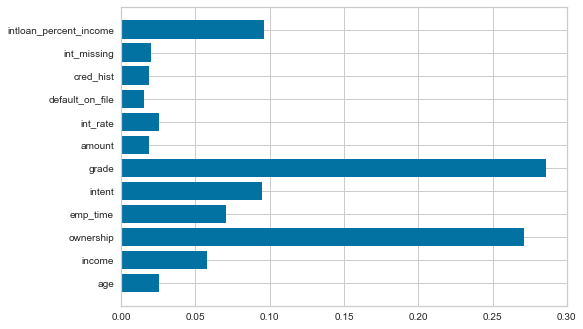

In [178]:
plt.barh(X_train.columns, xgb.feature_importances_)

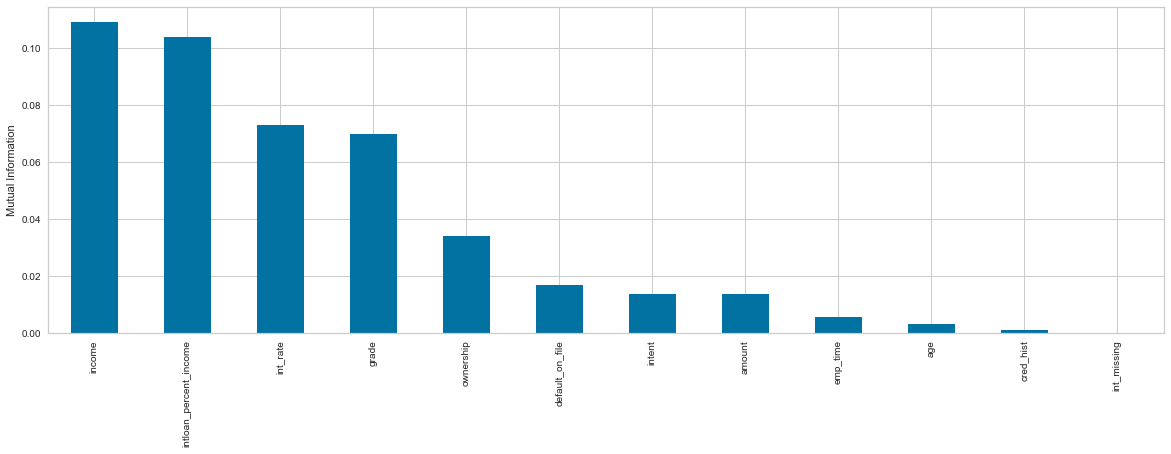

In [179]:
# this code from feature engineering by soledad galli

mi = mutual_info_classif(X_train, y_train)
mi = pd.Series(mi)
mi.index = X_train.columns
mi.sort_values(ascending=False).plot.bar(figsize=(20, 6))
plt.ylabel('Mutual Information');

In [236]:
X_train.drop("default_on_file", axis=1, inplace=True)
X_val.drop("default_on_file", axis=1, inplace=True)
X_test.drop("default_on_file", axis=1, inplace=True)

In [181]:
xgb = XGBClassifier(n_estimators=1000,
                   learning_rate=0.1,
                   max_depth=5)


xgb.fit(X_train, y_train, early_stopping_rounds=50, eval_metric="aucpr", eval_set=eval_set, verbose=False)

y_pred_train = xgb.predict(X_train)
y_pred_val = xgb.predict(X_val)
y_pred_test = xgb.predict(X_test)

print("Train Score: \n", classification_report(y_train, y_pred_train))
print("Validation Score: \n", classification_report(y_val, y_pred_val))
print("Test Score: \n", classification_report(y_test, y_pred_test))
print("train roc: ",roc_auc_score(y_train, y_pred_train))
print("val roc: ",roc_auc_score(y_val, y_pred_val))
print("Test roc: ", roc_auc_score(y_test, y_pred_test))

Train Score: 
               precision    recall  f1-score   support

           0       0.95      1.00      0.98     15280
           1       0.99      0.83      0.90      4265

    accuracy                           0.96     19545
   macro avg       0.97      0.91      0.94     19545
weighted avg       0.96      0.96      0.96     19545

Validation Score: 
               precision    recall  f1-score   support

           0       0.93      0.99      0.96      5094
           1       0.95      0.73      0.82      1421

    accuracy                           0.93      6515
   macro avg       0.94      0.86      0.89      6515
weighted avg       0.93      0.93      0.93      6515

Test Score: 
               precision    recall  f1-score   support

           0       0.93      0.99      0.96      5094
           1       0.95      0.75      0.84      1422

    accuracy                           0.94      6516
   macro avg       0.94      0.87      0.90      6516
weighted avg       0.94  

<BarContainer object of 11 artists>

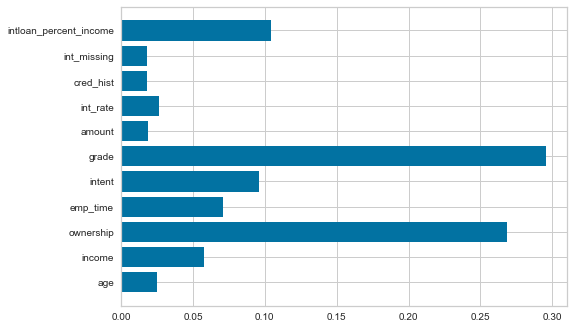

In [182]:
plt.barh(X_train.columns, xgb.feature_importances_)

In [237]:
X_train.drop(["int_missing", "cred_hist"], axis=1, inplace=True)
X_val.drop(["int_missing", "cred_hist"], axis=1, inplace=True)
X_test.drop(["int_missing", "cred_hist"], axis=1, inplace=True)

In [185]:
xgb = XGBClassifier(n_estimators=1000,
                   learning_rate=0.1,
                   max_depth=5)


xgb.fit(X_train, y_train, early_stopping_rounds=50, eval_metric="aucpr", eval_set=eval_set, verbose=False)

y_pred_train = xgb.predict(X_train)
y_pred_val = xgb.predict(X_val)
y_pred_test = xgb.predict(X_test)

print("Train Score: \n", classification_report(y_train, y_pred_train))
print("Validation Score: \n", classification_report(y_val, y_pred_val))
print("Test Score: \n", classification_report(y_test, y_pred_test))
print("train roc: ",roc_auc_score(y_train, y_pred_train))
print("val roc: ",roc_auc_score(y_val, y_pred_val))
print("Test roc: ", roc_auc_score(y_test, y_pred_test))

Train Score: 
               precision    recall  f1-score   support

           0       0.94      1.00      0.97     15280
           1       0.99      0.79      0.88      4265

    accuracy                           0.95     19545
   macro avg       0.97      0.89      0.92     19545
weighted avg       0.95      0.95      0.95     19545

Validation Score: 
               precision    recall  f1-score   support

           0       0.93      0.99      0.96      5094
           1       0.96      0.73      0.83      1421

    accuracy                           0.93      6515
   macro avg       0.94      0.86      0.89      6515
weighted avg       0.94      0.93      0.93      6515

Test Score: 
               precision    recall  f1-score   support

           0       0.93      0.99      0.96      5094
           1       0.96      0.75      0.84      1422

    accuracy                           0.94      6516
   macro avg       0.94      0.87      0.90      6516
weighted avg       0.94  

<BarContainer object of 9 artists>

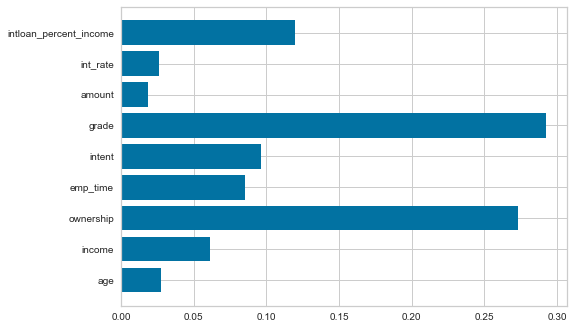

In [186]:
plt.barh(X_train.columns, xgb.feature_importances_)

In [238]:
X_train.drop("amount", axis=1, inplace=True)
X_val.drop("amount", axis=1, inplace=True)
X_test.drop("amount", axis=1, inplace=True)

In [188]:
xgb = XGBClassifier(n_estimators=1000,
                   learning_rate=0.1,
                   max_depth=5)


xgb.fit(X_train, y_train, early_stopping_rounds=50, eval_metric="aucpr", eval_set=eval_set, verbose=False)

y_pred_train = xgb.predict(X_train)
y_pred_val = xgb.predict(X_val)
y_pred_test = xgb.predict(X_test)

print("Train Score: \n", classification_report(y_train, y_pred_train))
print("Validation Score: \n", classification_report(y_val, y_pred_val))
print("Test Score: \n", classification_report(y_test, y_pred_test))
print("train roc: ",roc_auc_score(y_train, y_pred_train))
print("val roc: ",roc_auc_score(y_val, y_pred_val))
print("Test roc: ", roc_auc_score(y_test, y_pred_test))

Train Score: 
               precision    recall  f1-score   support

           0       0.95      1.00      0.97     15280
           1       0.99      0.80      0.88      4265

    accuracy                           0.95     19545
   macro avg       0.97      0.90      0.93     19545
weighted avg       0.96      0.95      0.95     19545

Validation Score: 
               precision    recall  f1-score   support

           0       0.93      0.99      0.96      5094
           1       0.96      0.73      0.83      1421

    accuracy                           0.93      6515
   macro avg       0.94      0.86      0.89      6515
weighted avg       0.94      0.93      0.93      6515

Test Score: 
               precision    recall  f1-score   support

           0       0.94      0.99      0.96      5094
           1       0.95      0.75      0.84      1422

    accuracy                           0.94      6516
   macro avg       0.94      0.87      0.90      6516
weighted avg       0.94  

<BarContainer object of 8 artists>

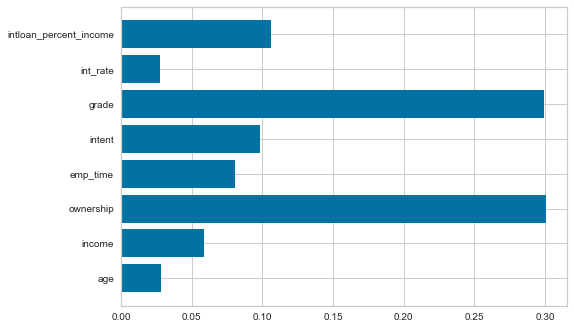

In [189]:
plt.barh(X_train.columns, xgb.feature_importances_)

In [239]:
X_train.drop("int_rate", axis=1, inplace=True)
X_val.drop("int_rate", axis=1, inplace=True)
X_test.drop("int_rate", axis=1, inplace=True)

In [242]:
xgb = XGBClassifier(n_estimators=1000,
                   learning_rate=0.1,
                   max_depth=5)


xgb.fit(X_train, y_train, early_stopping_rounds=50, eval_metric="aucpr", eval_set=eval_set, verbose=False)

y_pred_train = xgb.predict(X_train)
y_pred_val = xgb.predict(X_val)
y_pred_test = xgb.predict(X_test)

print("Train Score: \n", classification_report(y_train, y_pred_train))
print("Validation Score: \n", classification_report(y_val, y_pred_val))
print("Test Score: \n", classification_report(y_test, y_pred_test))
print("train roc: ",roc_auc_score(y_train, y_pred_train))
print("val roc: ",roc_auc_score(y_val, y_pred_val))
print("Test roc: ", roc_auc_score(y_test, y_pred_test))

Train Score: 
               precision    recall  f1-score   support

           0       0.94      1.00      0.97     15280
           1       0.98      0.78      0.87      4265

    accuracy                           0.95     19545
   macro avg       0.96      0.89      0.92     19545
weighted avg       0.95      0.95      0.95     19545

Validation Score: 
               precision    recall  f1-score   support

           0       0.93      0.99      0.96      5094
           1       0.95      0.74      0.83      1421

    accuracy                           0.93      6515
   macro avg       0.94      0.86      0.89      6515
weighted avg       0.93      0.93      0.93      6515

Test Score: 
               precision    recall  f1-score   support

           0       0.93      0.99      0.96      5094
           1       0.95      0.75      0.84      1422

    accuracy                           0.94      6516
   macro avg       0.94      0.87      0.90      6516
weighted avg       0.94  

# HYPERPARAMETER TUNING WITH MULTISTAGE GRIDSEARCH

In [247]:
param_grid = {"min_child_weight": [1, 2, 3, 4, 5, 7, 8, 10, 12, 20],
             "gamma": [0, 0.3, 0.5, 0.8, 1, 1.2, 2, 3]}


fit_params = {"eval_set":eval_set, "eval_metric":"aucpr", "early_stopping_rounds":50, "verbose":False}


xgb = XGBClassifier(n_estimators=1000,
                   learning_rate=0.1,
                   max_depth=5)

xgb_cv = GridSearchCV(xgb,
                      param_grid,
                      cv=3, 
                      n_jobs=-1, 
                      scoring="f1", 
                      verbose=4)

xgb_cv.fit(X_train, y_train, **fit_params)

Fitting 3 folds for each of 80 candidates, totalling 240 fits


GridSearchCV(cv=3, estimator=XGBClassifier(max_depth=5, n_estimators=1000),
             n_jobs=-1,
             param_grid={'gamma': [0, 0.3, 0.5, 0.8, 1, 1.2, 2, 3],
                         'min_child_weight': [1, 2, 3, 4, 5, 7, 8, 10, 12, 20]},
             scoring='f1', verbose=4)

In [248]:
xgb_cv.best_params_

{'gamma': 0.3, 'min_child_weight': 3}

In [249]:
xgb = XGBClassifier(n_estimators=1000,
                   learning_rate=0.1,
                   max_depth=5,
                   gamma=0.3,
                   min_child_weight=3)


xgb.fit(X_train, y_train, early_stopping_rounds=50, eval_metric="aucpr", eval_set=eval_set, verbose=False)

y_pred_train = xgb.predict(X_train)
y_pred_val = xgb.predict(X_val)
y_pred_test = xgb.predict(X_test)

print("Train Score: \n", classification_report(y_train, y_pred_train))
print("Validation Score: \n", classification_report(y_val, y_pred_val))
print("Test Score: \n", classification_report(y_test, y_pred_test))
print("train roc: ",roc_auc_score(y_train, y_pred_train))
print("val roc: ",roc_auc_score(y_val, y_pred_val))
print("Test roc: ", roc_auc_score(y_test, y_pred_test))

Train Score: 
               precision    recall  f1-score   support

           0       0.95      1.00      0.97     15280
           1       0.98      0.79      0.88      4265

    accuracy                           0.95     19545
   macro avg       0.96      0.89      0.92     19545
weighted avg       0.95      0.95      0.95     19545

Validation Score: 
               precision    recall  f1-score   support

           0       0.93      0.99      0.96      5094
           1       0.94      0.73      0.83      1421

    accuracy                           0.93      6515
   macro avg       0.94      0.86      0.89      6515
weighted avg       0.93      0.93      0.93      6515

Test Score: 
               precision    recall  f1-score   support

           0       0.94      0.99      0.96      5094
           1       0.94      0.76      0.84      1422

    accuracy                           0.94      6516
   macro avg       0.94      0.87      0.90      6516
weighted avg       0.94  

In [252]:
param_grid = {"reg_alpha": [1.2, 1.8, 2, 3, 5],
             "reg_lambda": [0.3, 0.8, 1, 1.2, 1.8, 2, 3,5]}


fit_params = {"eval_set":eval_set, "eval_metric":"aucpr", "early_stopping_rounds":50, "verbose":False}


xgb = XGBClassifier(n_estimators=1000,
                   learning_rate=0.1,
                   max_depth=5,
                   gamma=0.3,
                   min_child_weight=3)

xgb_cv = GridSearchCV(xgb,
                      param_grid,
                      cv=3, 
                      n_jobs=-1, 
                      scoring="f1", 
                      verbose=4)

xgb_cv.fit(X_train, y_train, **fit_params)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(gamma=0.3, max_depth=5, min_child_weight=3,
                                     n_estimators=1000),
             n_jobs=-1,
             param_grid={'reg_alpha': [1.2, 1.8, 2, 3, 5],
                         'reg_lambda': [0.3, 0.8, 1, 1.2, 1.8, 2, 3, 5]},
             scoring='f1', verbose=4)

In [253]:
xgb_cv.best_params_

{'reg_alpha': 1.2, 'reg_lambda': 2}

In [258]:
xgb = XGBClassifier(n_estimators=1000,
                   learning_rate=0.1,
                   max_depth=5,
                   gamma=0.3,
                   min_child_weight=3,
                   reg_alpha=1.2,
                   reg_lambda=2)


xgb.fit(X_train, y_train, early_stopping_rounds=50, eval_metric="aucpr", eval_set=eval_set, verbose=False)

y_pred_train = xgb.predict(X_train)
y_pred_val = xgb.predict(X_val)
y_pred_test = xgb.predict(X_test)

print("Train Score: \n", classification_report(y_train, y_pred_train))
print("Validation Score: \n", classification_report(y_val, y_pred_val))
print("Test Score: \n", classification_report(y_test, y_pred_test))
print("train roc: ",roc_auc_score(y_train, y_pred_train))
print("val roc: ",roc_auc_score(y_val, y_pred_val))
print("Test roc: ", roc_auc_score(y_test, y_pred_test))

Train Score: 
               precision    recall  f1-score   support

           0       0.94      0.99      0.97     15280
           1       0.98      0.77      0.86      4265

    accuracy                           0.94     19545
   macro avg       0.96      0.88      0.91     19545
weighted avg       0.95      0.94      0.94     19545

Validation Score: 
               precision    recall  f1-score   support

           0       0.93      0.99      0.96      5094
           1       0.95      0.73      0.83      1421

    accuracy                           0.93      6515
   macro avg       0.94      0.86      0.89      6515
weighted avg       0.93      0.93      0.93      6515

Test Score: 
               precision    recall  f1-score   support

           0       0.93      0.99      0.96      5094
           1       0.95      0.75      0.84      1422

    accuracy                           0.94      6516
   macro avg       0.94      0.87      0.90      6516
weighted avg       0.94  

In [260]:
param_grid = {"subsample": [0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95],
             "colsample_bytree": [0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]}


fit_params = {"eval_set":eval_set, "eval_metric":"aucpr", "early_stopping_rounds":50, "verbose":False}


xgb = XGBClassifier(n_estimators=1000,
                   learning_rate=0.1,
                   max_depth=5,
                   gamma=0.3,
                   min_child_weight=3,
                   reg_alpha=1.2,
                   reg_lambda=2)

xgb_cv = GridSearchCV(xgb,
                      param_grid,
                      cv=3, 
                      n_jobs=-1, 
                      scoring="f1", 
                      verbose=4)

xgb_cv.fit(X_train, y_train, **fit_params)

Fitting 3 folds for each of 56 candidates, totalling 168 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(gamma=0.3, max_depth=5, min_child_weight=3,
                                     n_estimators=1000, reg_alpha=1.2,
                                     reg_lambda=2),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 0.6, 0.7, 0.75, 0.8, 0.85,
                                              0.9, 0.95],
                         'subsample': [0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]},
             scoring='f1', verbose=4)

In [261]:
xgb_cv.best_params_

{'colsample_bytree': 0.75, 'subsample': 0.9}

In [267]:
xgb = XGBClassifier(n_estimators=1000,
                   learning_rate=0.1,
                   max_depth=5,
                   gamma=0.3,
                   min_child_weight=3,
                   reg_alpha=1.2,
                   reg_lambda=2,
                   colsample_bytree=0.75,
                   subsample=0.9)


xgb.fit(X_train, y_train, early_stopping_rounds=50, eval_metric="aucpr", eval_set=eval_set, verbose=False)

y_pred_train = xgb.predict(X_train)
y_pred_val = xgb.predict(X_val)
y_pred_test = xgb.predict(X_test)

print("Train Score: \n", classification_report(y_train, y_pred_train))
print("Validation Score: \n", classification_report(y_val, y_pred_val))
print("Test Score: \n", classification_report(y_test, y_pred_test))
print("train roc: ",roc_auc_score(y_train, y_pred_train))
print("val roc: ",roc_auc_score(y_val, y_pred_val))
print("Test roc: ", roc_auc_score(y_test, y_pred_test))

Train Score: 
               precision    recall  f1-score   support

           0       0.94      1.00      0.97     15280
           1       0.98      0.77      0.86      4265

    accuracy                           0.95     19545
   macro avg       0.96      0.88      0.92     19545
weighted avg       0.95      0.95      0.94     19545

Validation Score: 
               precision    recall  f1-score   support

           0       0.93      0.99      0.96      5094
           1       0.94      0.74      0.83      1421

    accuracy                           0.93      6515
   macro avg       0.94      0.86      0.89      6515
weighted avg       0.93      0.93      0.93      6515

Test Score: 
               precision    recall  f1-score   support

           0       0.93      0.99      0.96      5094
           1       0.95      0.75      0.84      1422

    accuracy                           0.94      6516
   macro avg       0.94      0.87      0.90      6516
weighted avg       0.94  

In [275]:
param_grid = {"scale_pos_weight": np.arange(1,4.1, 0.1)}


fit_params = {"eval_set":eval_set, "eval_metric":"aucpr", "early_stopping_rounds":50, "verbose":False}


xgb = XGBClassifier(n_estimators=1000,
                   learning_rate=0.1,
                   max_depth=5,
                   gamma=0.3,
                   min_child_weight=3,
                   reg_alpha=1.2,
                   reg_lambda=2,
                   colsample_bytree=0.75,
                   subsample=0.9)

xgb_cv = GridSearchCV(xgb,
                      param_grid,
                      cv=3, 
                      n_jobs=-1, 
                      scoring="f1", 
                      verbose=4)

xgb_cv.fit(X_train, y_train, **fit_params)

Fitting 3 folds for each of 31 candidates, totalling 93 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(colsample_bytree=0.75, gamma=0.3,
                                     max_depth=5, min_child_weight=3,
                                     n_estimators=1000, reg_alpha=1.2,
                                     reg_lambda=2, subsample=0.9),
             n_jobs=-1,
             param_grid={'scale_pos_weight': array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2,
       2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5,
       3.6, 3.7, 3.8, 3.9, 4. ])},
             scoring='f1', verbose=4)

In [276]:
xgb_cv.best_params_

{'scale_pos_weight': 1.1}

In [277]:
xgb = XGBClassifier(n_estimators=1000,
                   learning_rate=0.1,
                   max_depth=5,
                   gamma=0.3,
                   min_child_weight=3,
                   reg_alpha=1.2,
                   reg_lambda=2,
                   colsample_bytree=0.75,
                   subsample=0.9,
                   scale_pos_weight=1.1)


xgb.fit(X_train, y_train, early_stopping_rounds=50, eval_metric="aucpr", eval_set=eval_set, verbose=False)

y_pred_train = xgb.predict(X_train)
y_pred_val = xgb.predict(X_val)
y_pred_test = xgb.predict(X_test)

print("Train Score: \n", classification_report(y_train, y_pred_train))
print("Validation Score: \n", classification_report(y_val, y_pred_val))
print("Test Score: \n", classification_report(y_test, y_pred_test))
print("train roc: ",roc_auc_score(y_train, y_pred_train))
print("val roc: ",roc_auc_score(y_val, y_pred_val))
print("Test roc: ", roc_auc_score(y_test, y_pred_test))

Train Score: 
               precision    recall  f1-score   support

           0       0.94      0.99      0.97     15280
           1       0.98      0.78      0.87      4265

    accuracy                           0.95     19545
   macro avg       0.96      0.89      0.92     19545
weighted avg       0.95      0.95      0.95     19545

Validation Score: 
               precision    recall  f1-score   support

           0       0.93      0.99      0.96      5094
           1       0.93      0.74      0.83      1421

    accuracy                           0.93      6515
   macro avg       0.93      0.86      0.89      6515
weighted avg       0.93      0.93      0.93      6515

Test Score: 
               precision    recall  f1-score   support

           0       0.94      0.99      0.96      5094
           1       0.94      0.76      0.84      1422

    accuracy                           0.94      6516
   macro avg       0.94      0.87      0.90      6516
weighted avg       0.94  

In [278]:
param_grid = {"max_delta_step": [2,3,4,5,6,7,8,9]}


fit_params = {"eval_set":eval_set, "eval_metric":"aucpr", "early_stopping_rounds":50, "verbose":False}


xgb = XGBClassifier(n_estimators=1000,
                   learning_rate=0.1,
                   max_depth=5,
                   gamma=0.3,
                   min_child_weight=3,
                   reg_alpha=1.2,
                   reg_lambda=2,
                   colsample_bytree=0.75,
                   subsample=0.9,
                   scale_pos_weight=1.1)

xgb_cv = GridSearchCV(xgb,
                      param_grid,
                      cv=3, 
                      n_jobs=-1, 
                      scoring="f1", 
                      verbose=4)

xgb_cv.fit(X_train, y_train, **fit_params)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(colsample_bytree=0.75, gamma=0.3,
                                     max_depth=5, min_child_weight=3,
                                     n_estimators=1000, reg_alpha=1.2,
                                     reg_lambda=2, scale_pos_weight=1.1,
                                     subsample=0.9),
             n_jobs=-1, param_grid={'max_delta_step': [2, 3, 4, 5, 6, 7, 8, 9]},
             scoring='f1', verbose=4)

In [279]:
xgb_cv.best_params_

{'max_delta_step': 3}

In [292]:
xgb = XGBClassifier(n_estimators=1000,
                   learning_rate=0.1,
                   max_depth=5,
                   gamma=0.3,
                   min_child_weight=3,
                   reg_alpha=1.2,
                   reg_lambda=2,
                   colsample_bytree=0.75,
                   subsample=0.9,
                   scale_pos_weight=1.1,
                   max_delta_step=3)


xgb.fit(X_train, y_train, early_stopping_rounds=50, eval_metric="aucpr", eval_set=eval_set, verbose=False)

y_pred_train = xgb.predict(X_train)
y_pred_val = xgb.predict(X_val)
y_pred_test = xgb.predict(X_test)

print("Train Score: \n", classification_report(y_train, y_pred_train))
print("Validation Score: \n", classification_report(y_val, y_pred_val))
print("Test Score: \n", classification_report(y_test, y_pred_test))
print("train roc: ",roc_auc_score(y_train, y_pred_train))
print("val roc: ",roc_auc_score(y_val, y_pred_val))
print("Test roc: ", roc_auc_score(y_test, y_pred_test))

Train Score: 
               precision    recall  f1-score   support

           0       0.94      0.99      0.97     15280
           1       0.98      0.78      0.87      4265

    accuracy                           0.95     19545
   macro avg       0.96      0.89      0.92     19545
weighted avg       0.95      0.95      0.95     19545

Validation Score: 
               precision    recall  f1-score   support

           0       0.93      0.99      0.96      5094
           1       0.93      0.74      0.83      1421

    accuracy                           0.93      6515
   macro avg       0.93      0.86      0.89      6515
weighted avg       0.93      0.93      0.93      6515

Test Score: 
               precision    recall  f1-score   support

           0       0.94      0.99      0.96      5094
           1       0.94      0.76      0.84      1422

    accuracy                           0.94      6516
   macro avg       0.94      0.87      0.90      6516
weighted avg       0.94  

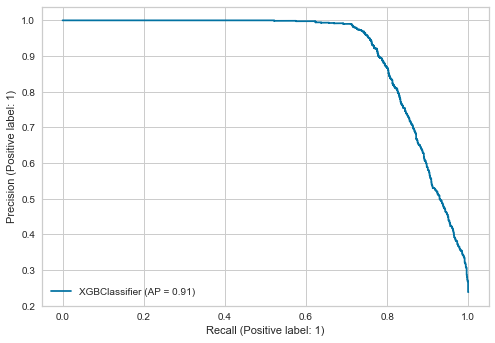

In [293]:
xgb_disp = plot_precision_recall_curve(xgb, X_test, y_test)

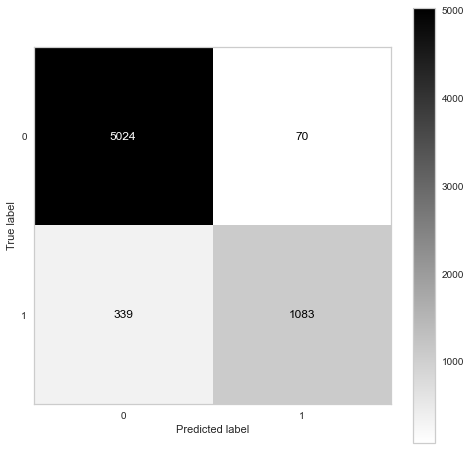

In [294]:
cm = confusion_matrix(y_test, y_pred_test, labels=xgb.classes_)
cmp = ConfusionMatrixDisplay(cm, display_labels=xgb.classes_)
fig, ax = plt.subplots(figsize=(8,8))
ax.grid(False)

cmp.plot(ax=ax, cmap='binary');

# Optimum Threshold 

In [296]:
y_proba_test = xgb.predict_proba(X_test)[:,1]

In [314]:
test_score = np.where(y_proba_test>0.26, 1, 0)

In [315]:
print("Test Score: \n", classification_report(y_test, test_score))

Test Score: 
               precision    recall  f1-score   support

           0       0.95      0.94      0.95      5094
           1       0.80      0.83      0.81      1422

    accuracy                           0.92      6516
   macro avg       0.88      0.88      0.88      6516
weighted avg       0.92      0.92      0.92      6516



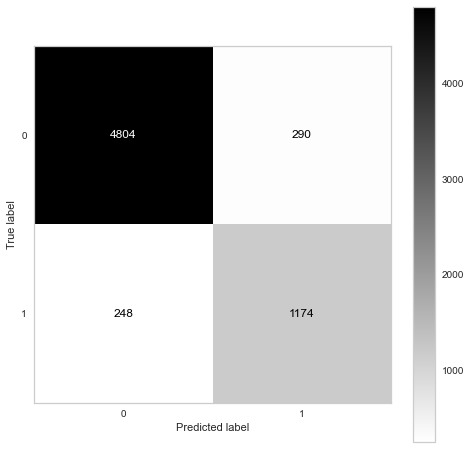

In [317]:
cm = confusion_matrix(y_test, test_score, labels=xgb.classes_)
cmp = ConfusionMatrixDisplay(cm, display_labels=xgb.classes_)
fig, ax = plt.subplots(figsize=(8,8))
ax.grid(False)

cmp.plot(ax=ax, cmap='binary');

    Our main aim is maximizing to recall score under the condition of %80 precision score. According to this aim, the best threshold value is 0.26. 

# Calibration Curve

In [318]:
predictions = xgb.predict_proba(X_test)[:,1]

calibration_curve(y_test, predictions, n_bins=5)

(array([0.0428866 , 0.24242424, 0.39490446, 0.68571429, 0.99009901]),
 array([0.04929848, 0.27547896, 0.49383776, 0.69699486, 0.97467278]))

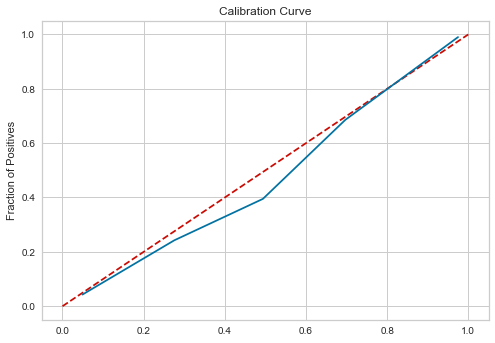

In [319]:
frac_pos = [0.0428866 , 0.24242424, 0.39490446, 0.68571429, 0.99009901]
avg_prob = [0.04929848, 0.27547896, 0.49383776, 0.69699486, 0.97467278]

plt.plot([0,1],[0,1], "r--")
plt.plot(avg_prob, frac_pos)
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curve");

# CONCLUSION

    
    
    All of feature engineering process calculated with training set for avoiding data leakage. And we used validation   set for feature selection, hyperparameter tuning and early stopping. Afterwards we test our model with test set for unbiased scoring.    
    
    We see that the optimized XGBoost model is a lot better at identifying people who cannot afford their loans. If the 
    model predict to a loan as default, it is %80 true. The model catchs %83 of total defaulted loans... 